In [660]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cm

from skimage.measure import find_contours
from skimage.measure import label, regionprops
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import find_contours, perimeter


import sys
sys.path.append('../../util')
from curvature import *

In [648]:
#Import simulation
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/' #Path for Daint

In [426]:
#Read Data
d2D = xr.open_mfdataset(path+'output/lfff[2,3]???0000.nc', combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [515]:
#Mask of all moist regions
bFMSE = np.where(d2D.FMSE > np.median(d2D.FMSE, axis=(1,2))[:, np.newaxis, np.newaxis], 1, 0)
#Need to fill holes
bFMSE = binary_fill_holes(bFMSE)

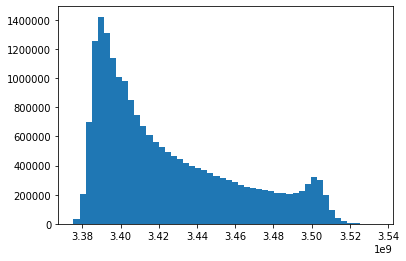

In [4]:
fig = plt.hist(d2D.FMSE.values.flatten(), bins=50)

In [427]:
def find_sepmin_bin(field,vmin=45,vmax=55,N_bins=30):
# Inputs
# field = field from which to take the pdf
# vmin = minimal value of the interval over which min(PDF) will be searched
# vmax = maximal value //
# bins = Number of bins of the PDF

    field_hist,bin_edges = np.histogram(field.flatten(),bins=N_bins)
    bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

    binary = (bin_mid<vmax)*(bin_mid>vmin)
    imin =  np.argmin(field_hist[binary])+np.argmax(binary)

    return bin_mid[imin],bin_mid

In [513]:
#Mask of all moist regions
#This approach onyl works after day 20, one the distribution becomes bimodal
bFMSE = np.zeros(np.shape(d2D.FMSE))
for t, FMSE in enumerate(d2D.FMSE.values):
    th = find_sepmin_bin(FMSE, vmin=np.amin(FMSE),vmax=3.5e9)
    bFMSE[t,:,:] = np.where(FMSE > th[0], 1, 0)

#Need to fill holes
bFMSE = binary_fill_holes(bFMSE)

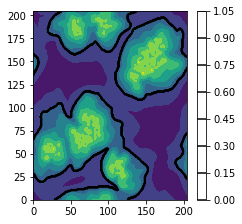

In [587]:
plt.figure(figsize=(20, 16))
for t in range(1,2):
    plt.subplot(4,5,t+1)
    plt.contourf(d2D.FMSE[t*12,:,:], cmap = 'viridis')
    plt.contour(bFMSE[t*12,:,:], colors = 'k')
plt.colorbar()

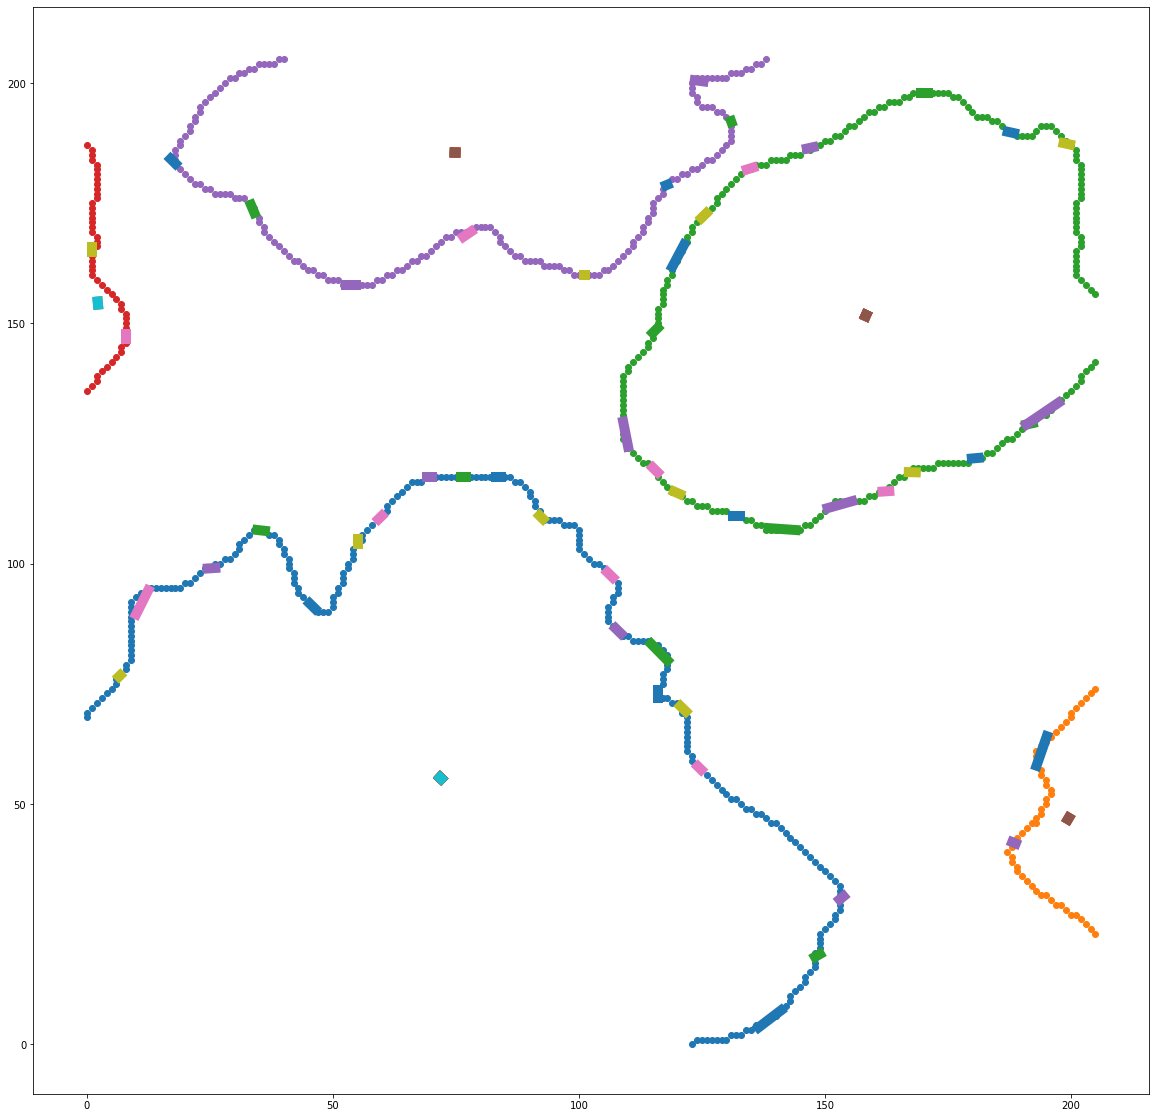

In [671]:
d_min = 10 #Tuning constant for minimum distance between objects
c_minlength = 20 #minimum lengh of contour
dx = 3300

#Search for the closest matching point
velocity = np.array([])
vel_x = np.array([])
vel_y = np.array([])
curvature = np.array([])
curvature_old = np.array([])

fig = plt.figure(figsize=(20, 20))

for t in range(1, 2, 1):

    labels = label(bFMSE[t,:,:], neighbors=8)
    props = regionprops(labels, cache=False)
    
    labels_old = label(bFMSE[t-1,:,:], neighbors=8)
    props_old = regionprops(labels_old, cache=False)
        
    y0_old = []
    x0_old = []
    for p in range(len(props_old)):
        y0_old.append(props_old[p].centroid[0])
        x0_old.append(props_old[p].centroid[1])

    #Loop over all objects in the current timestep
    for p in range(len(props)):
        y0, x0 = props[p].centroid

        d_centroids = np.sqrt((x0_old-x0)**2 + (y0_old-y0)**2) #Distance between all the centroid
            
        if d_min > np.amin(d_centroids): #Maximum distance between centroids objects

                
            #Find extremas for timestep t and t - 1 
            fld = np.zeros((206,206))
            fld[props[p].coords[:, 0], props[p].coords[:, 1]] = 1
            contour = find_contours(fld, 0)
            
            if len(contour[-1]) < c_minlength: #Protect against small objects
                continue

            xc, yc, curv = calc_curv(contour[-1][:,1], contour[-1][:,0])
            extremas, ex, ey = get_extrema(curv, xc, yc, filter=False)

            fld_old = np.zeros((206,206))
            fld_old[props_old[np.argmin(d_centroids)].coords[:, 0], props_old[np.argmin(d_centroids)].coords[:, 1]] = 1
            contour_old = find_contours(fld_old, 0)
            plt.scatter(contour_old[-1][:,1], contour_old[-1][:,0])
            plt.draw()

            if len(contour_old[-1]) < c_minlength: #Protect against small objects
                continue

            xc_old, yc_old, curv_old = calc_curv(contour_old[-1][:,1], contour_old[-1][:,0])
            extremas_old, ex_old, ey_old = get_extrema(curv_old, xc_old, yc_old, filter=False)
                
            #Loop over extremas of current contour and match with extremas of the same contour at t-1
            for n in range(len(ex)): 
                d_extremas = np.sqrt((ex_old-ex[n])**2 + (ey_old-ey[n])**2) #Distance between all the points
   
                if 1 > np.amin(d_e):#Only consider points that move
                    continue
    
                if np.amin(d_e) > d_min: #Very fast points are false positives
                    continue

                if 0.0 == extremas[n]: #Only consider points that are curved
                    continue
                    
                
                #Compute movement of point relative to centroids
                vel = np.sqrt((ex[n] - ex_old[np.argmin(d_extremas)] - 2*x0 + x0_old[np.argmin(d_centroids)])**2 + (ey[n] - ey_old[np.argmin(d_extremas)] - 2*y0  + y0_old[np.argmin(d_centroids)])**2)
                
                plt.plot([ex[n], ex_old[np.argmin(d_extremas)]], [ey[n], ey_old[np.argmin(d_extremas)]], linewidth=10)
                plt.plot([x0 , x0_old[np.argmin(d_centroids)]], [y0 , y0_old[np.argmin(d_centroids)]], linewidth=10)
                                                                  
                vel_x = np.append(vel_x, np.sqrt((x0_old[np.argmin(d_centroids)] )**2))
                vel_y = np.append(vel_y, np.sqrt((y0_old[np.argmin(d_centroids)] )**2))
                velocity = np.append(velocity, vel)
                curvature     = np.append(curvature, extremas[n])


Text(0, 0.5, 'Rdot')

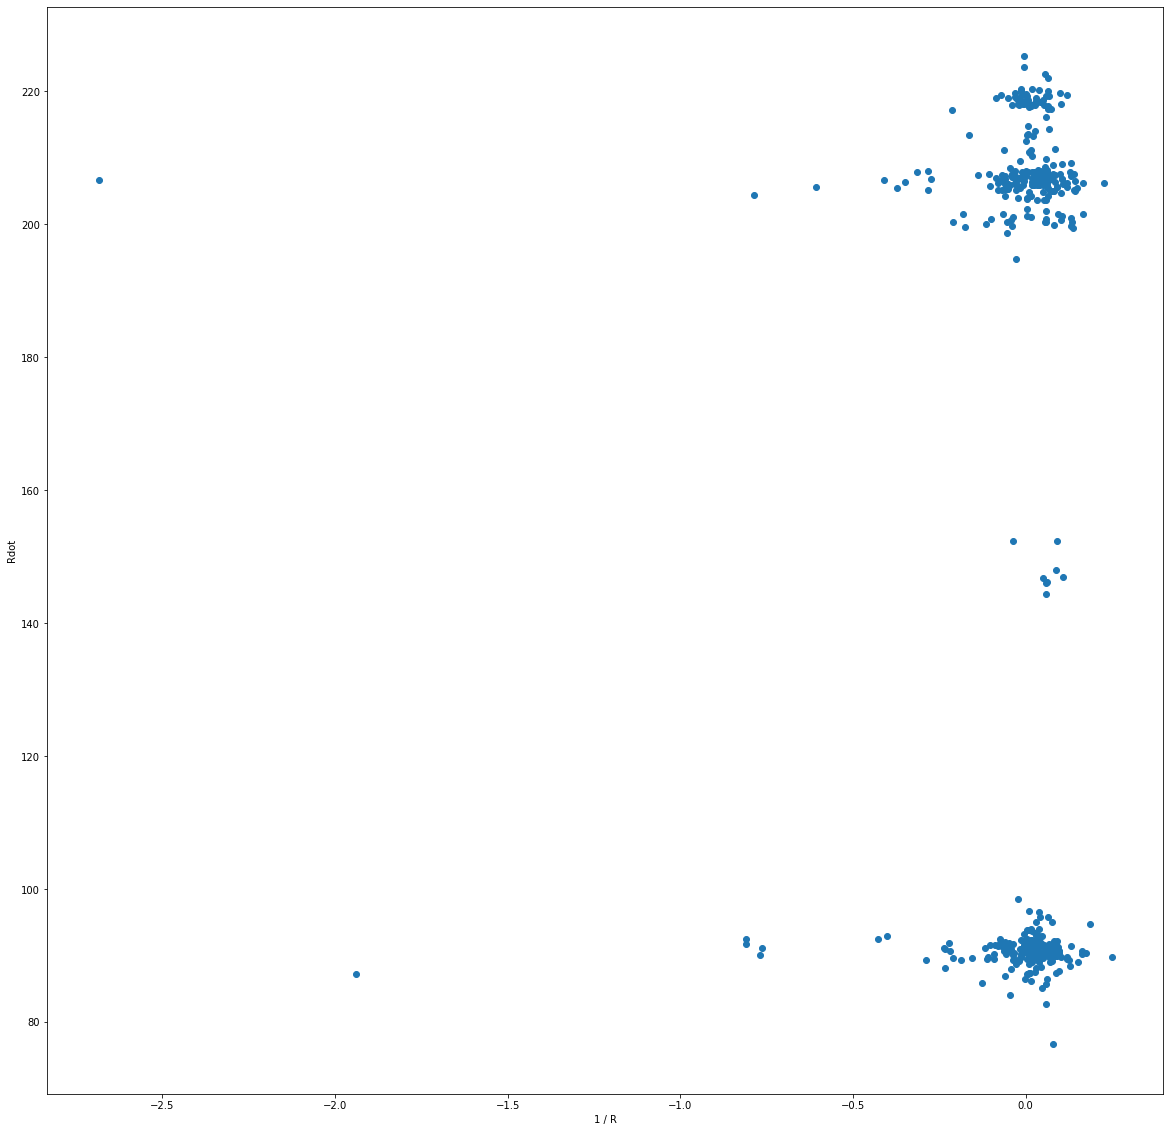

In [662]:

fig = plt.figure(figsize=(20, 20))

plt.scatter(curvature, velocity)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('1 / R')
plt.ylabel('Rdot')

